## This notebook does Fourier deconvolution of the STN subregion timeseries

The main point is to check:
- data quality (is there any BOLD response detectible?) 
- model quality (does the HRF capture the shape of the BOLD response?)

In [2]:
import pandas as pd
import numpy as np
import os

import glob
import re
import seaborn as sns

import nideconv
from nideconv import GroupResponseFitter

import matplotlib.pyplot as plt
%matplotlib inline

## Entire STN (no subregions) first

In [3]:
events = pd.read_pickle('./derivatives/all_subjects_events.pkl')
confounds = pd.read_pickle('./derivatives/all_subjects_confounds.pkl')
df = pd.read_pickle('./derivatives/all_subjects_whole_stn_timeseries.pkl')

events['onset'] -= 1.5  # slice timing correction

In [4]:
events.loc[events['event_type'].isin(['cue_left', 'cue_right', 'cue_neutral']), 'event_type'] = 'cue'
events.loc[events['event_type'].isin(['easy', 'hard']), 'event_type'] = 'stim'
events['event_type'] = events['event_type'].replace({'cue_left': 'cue', 'cue_right': 'cue', 'cue_neutral': 'cue',
                                                     'easy': 'stim', 'hard': 'stim',
                                                     'feedback_+0.04': 'feedback',
                                                     'feedback_+0.025': 'feedback',
                                                     'feedback_+0.01': 'feedback',
                                                     'feedback_0': 'feedback'})
events = events.loc[events['event_type'].isin(['cue', 'stim', 'feedback'])]
events.head()

onset event_type  duration
subject run                            
1       1     6.00        cue     0.001
        1     8.75       stim     0.001
        1    10.25   feedback     0.001
        1    15.00        cue     0.001
        1    17.75       stim     0.001

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2819: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


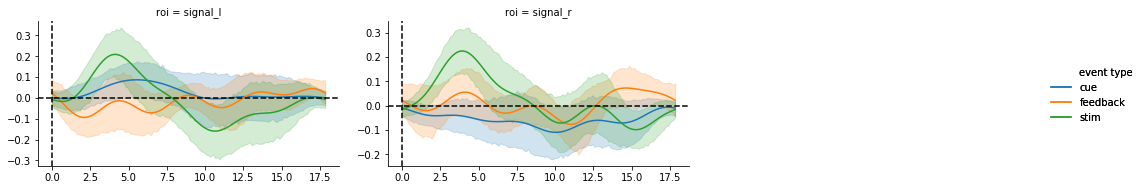

In [5]:
event_types = ['stim', 'cue', 'feedback']
gmodel_full = GroupResponseFitter(df, 
                                  events, 
                                  confounds=confounds.reset_index(),
                                  input_sample_rate=1/3, concatenate_runs=True)
for event_type in event_types:
    gmodel_full.add_event(event_type, basis_set='fourier', n_regressors=9, interval=[0, 18])

gmodel_full.fit()
fg_full = gmodel_full.plot_groupwise_timecourses(event_types=event_types, ci=95, col_wrap=3, plots='covariate', col='roi')

### So the STNs seem to respond to the presentation of a stimulus, but are not very impressed by the cues or feedback

# Subregions

In [6]:
events = pd.read_pickle('./derivatives/all_subjects_events.pkl')
confounds = pd.read_pickle('./derivatives/all_subjects_confounds.pkl')
df = pd.read_pickle('./derivatives/all_subjects_stn_timeseries.pkl')

events['onset'] -= 1.5  # slice timing correction

## Fourier basis set deconvolution

In [7]:
events.loc[events['event_type'].isin(['cue_left', 'cue_right', 'cue_neutral']), 'event_type'] = 'cue'
events.loc[events['event_type'].isin(['easy', 'hard']), 'event_type'] = 'stim'
events['event_type'] = events['event_type'].replace({'cue_left': 'cue', 'cue_right': 'cue', 'cue_neutral': 'cue',
                                                     'easy': 'stim', 'hard': 'stim'})
events = events.loc[events['event_type'].isin(['cue', 'stim'])]
events.head()

onset event_type  duration
subject run                            
1       1     6.00        cue     0.001
        1     8.75       stim     0.001
        1    10.25   feedback     0.001
        1    15.00        cue     0.001
        1    17.75       stim     0.001

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2819: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


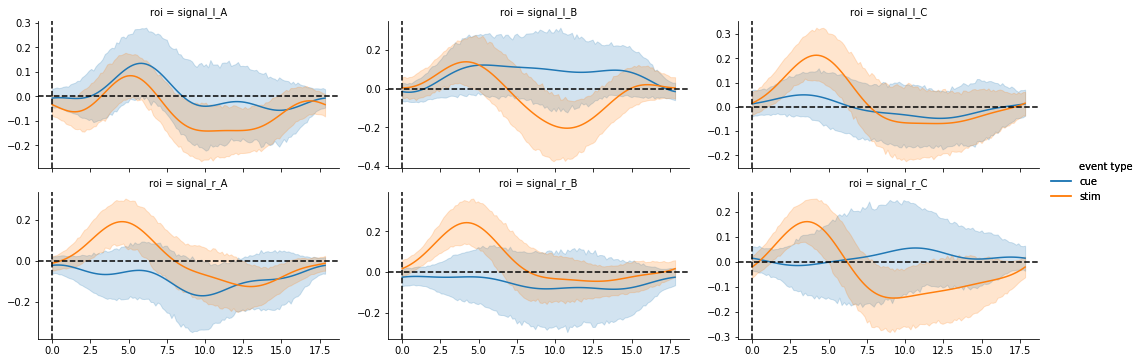

In [8]:
event_types = ['stim', 'cue']
gmodel_full = GroupResponseFitter(df, 
                                  events, 
                                  confounds=confounds.reset_index(),
                                  input_sample_rate=1/3, concatenate_runs=True)
for event_type in event_types:
    gmodel_full.add_event(event_type, basis_set='fourier', n_regressors=7, interval=[0, 18])

gmodel_full.fit()
fg_full = gmodel_full.plot_groupwise_timecourses(event_types=event_types, ci=95, col_wrap=3, plots='covariate', col='roi')

We seem to observe a consistent BOLD-response after a stimulus onset, although the peak is a bit earlier than the canonical HRF. The cue has no consistent effect, seems mostly absent except for in L_A

## Any difference between data sets?

Text(0.5, 0.98, 'Amsterdam')

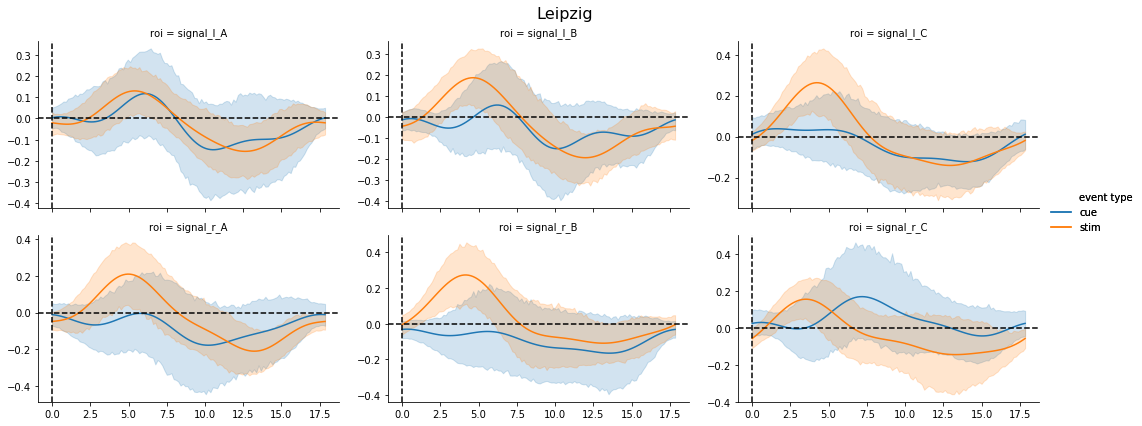

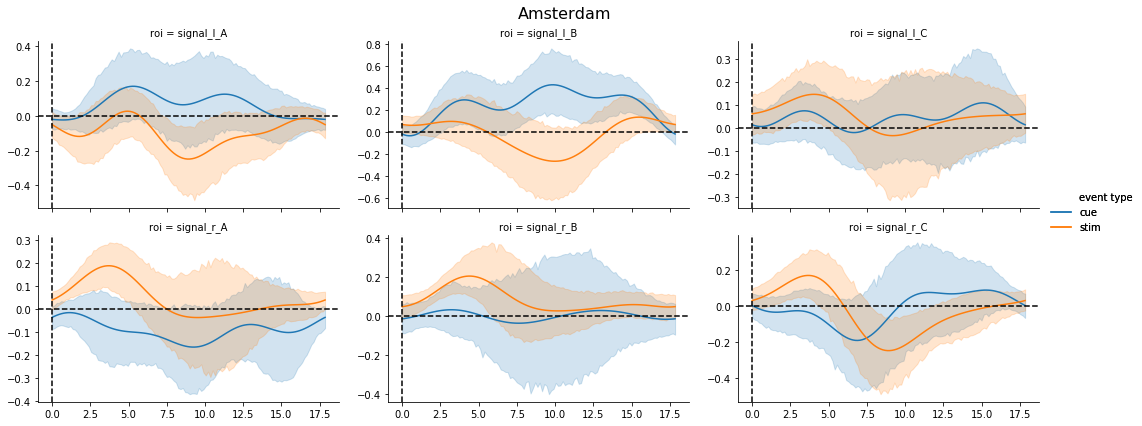

In [104]:
# ds-01: Leipzig
events_ = events.copy().loc[:19]
df_ = df.copy().loc[:19]
confounds_ = confounds.copy().loc[:19] #.reset_index()

gmodelL = GroupResponseFitter(df_, 
                              events_, 
                              confounds=confounds_,
                              input_sample_rate=1/3, concatenate_runs=True)
for event_type in event_types:
    gmodelL.add_event(event_type, basis_set='fourier', n_regressors=7, interval=[0, 18])

gmodelL.fit()
fg_Leipzig = gmodelL.plot_groupwise_timecourses(event_types=['cue', 'stim'], ci=95, col_wrap=3, plots='covariate', col='roi')
fg_Leipzig[0].fig.subplots_adjust(top=0.9)
fg_Leipzig[0].fig.suptitle('Leipzig', fontsize=16)

# ds-02: Amsterdam
events_ = events.copy().loc[20:]
df_ = df.copy().loc[20:]
confounds_ = confounds.copy().loc[20:]

gmodelA = GroupResponseFitter(df_, 
                              events_, 
                              confounds=confounds_,
                              input_sample_rate=1/3, concatenate_runs=True)
gmodelA.add_event('stim', basis_set='fourier', n_regressors=7, interval=[0, 18])
gmodelA.add_event('cue', basis_set='fourier', n_regressors=7, interval=[0, 18])

gmodelA.fit()
fg_Amsterdam = gmodelA.plot_groupwise_timecourses(event_types=['cue', 'stim'], ci=95, col_wrap=3, plots='covariate', col='roi')
fg_Amsterdam[0].fig.subplots_adjust(top=0.9)
fg_Amsterdam[0].fig.suptitle('Amsterdam', fontsize=16)

The Leipzig data appears a bit 'cleaner', although in both datasets, a BOLD response seems present for most subregions after a stimulus

## How well does the canonical HRF capture the BOLD-response without a temporal derivative?

#### 1. Fourier basis set

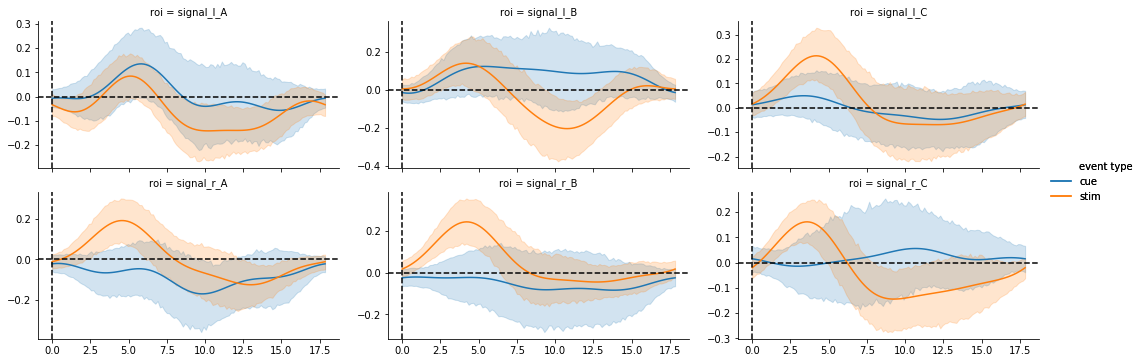

In [105]:
gmodel_full.plot_groupwise_timecourses(event_types=event_types, ci=95, col_wrap=3, plots='covariate', col='roi')

#### 2. Canonical HRF without derivative

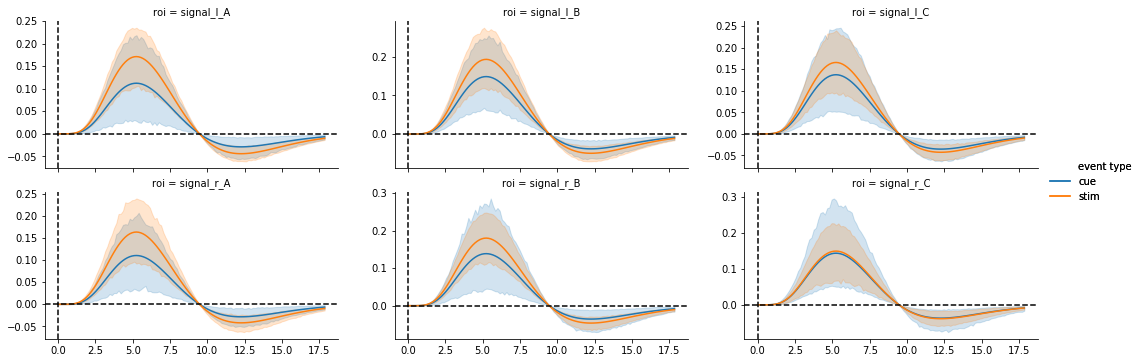

In [106]:
event_types = ['stim', 'cue']
gmodel = GroupResponseFitter(df, 
                             events, 
                             confounds=confounds.reset_index(),
                             input_sample_rate=1/3, concatenate_runs=True)
for event_type in event_types:
    gmodel.add_event(event_type, basis_set='canonical_hrf', interval=[0,18])

gmodel.fit()
gmodel.plot_groupwise_timecourses(event_types=event_types, ci=95, col_wrap=3, plots='covariate', col='roi')

#### 3. Canonical HRF with derivative

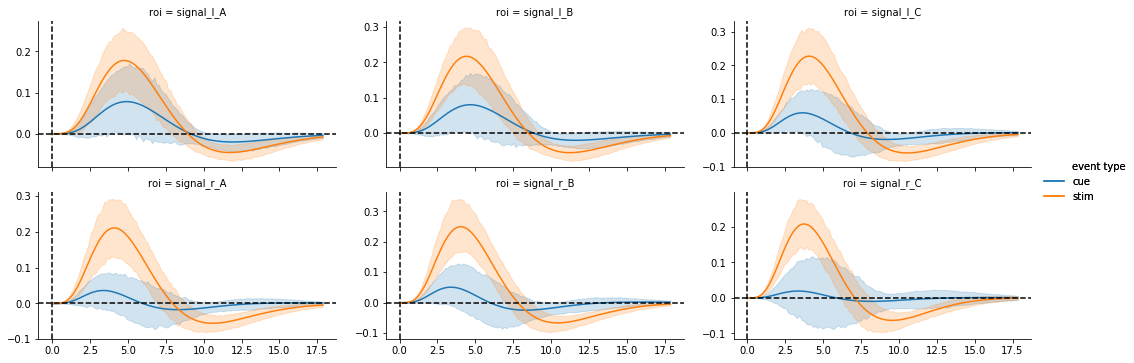

In [107]:
event_types = ['stim', 'cue']
events_ = events.copy()
gmodel = GroupResponseFitter(df, 
                             events_, 
                             confounds=confounds.reset_index(),
                             input_sample_rate=1/3, concatenate_runs=True)
for event_type in event_types:
    gmodel.add_event(event_type, basis_set='canonical_hrf_with_time_derivative', interval=[0,18])

gmodel.fit()
gmodel.plot_groupwise_timecourses(event_types=event_types, ci=95, col_wrap=3, plots='covariate', col='roi')

Clearly, the addition of the temporal derivative seems to improve the model fit (assuming the fourier deconvolution is the ground truth, which it isnt)

## Do the parameter estiamtes of the HRF regressor reflect the peak sizes properly?

/home/stevenm/.conda/envs/python3/lib/python3.6/site-packages/pandas/core/indexing.py:1494: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


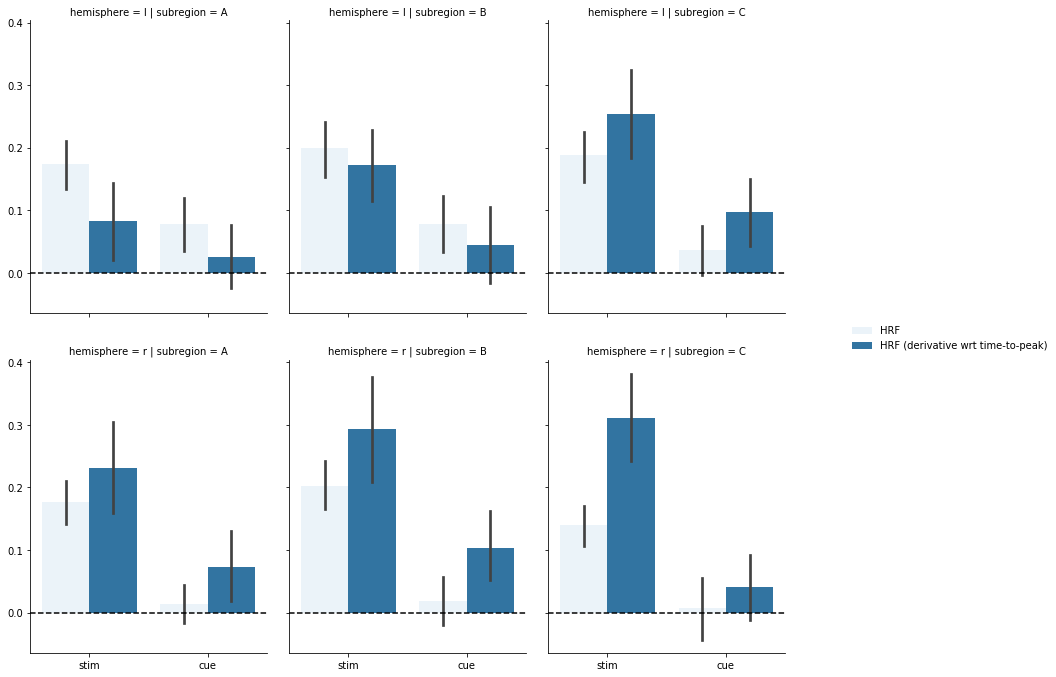

In [108]:
betas = pd.concat(gmodel.concat_response_fitters.apply(lambda x: x.betas).values)
betas = betas.loc[(('stim', 'cue'), 'intercept', ('HRF', 'HRF (derivative wrt time-to-peak)'))].reset_index(level=[1], drop=True)
betas['subject'] = np.repeat(np.arange(1, 34), 4)
betas = betas.reset_index().set_index(['subject', 'event type', 'regressor'])
betas = betas.reset_index().melt(id_vars=['subject', 'event type', 'regressor'], var_name='roi', value_name='beta')

betas['hemisphere'] = betas['roi'].str.split('_').apply(lambda x: x[1])
betas['subregion'] = betas['roi'].str.split('_').apply(lambda x: x[2])

## Plot
fac = sns.FacetGrid(betas, row='hemisphere', col='subregion')
fac.map_dataframe(sns.barplot,
                  hue='regressor',
                  x='event type',
                  y='beta', order=['stim', 'cue'], ci=67)
fac.map(plt.axhline, y=0, c='k', ls='--')
fac.add_legend()

plt.gcf().set_size_inches(15,10)

## Conclusions
Although there is a bit of an offset in the BOLD response timing, it appears that the peak value is at least approximately correctly reflected by the canonical HRF regressor size when a temporal derivative is added to the model

## Figure for paper

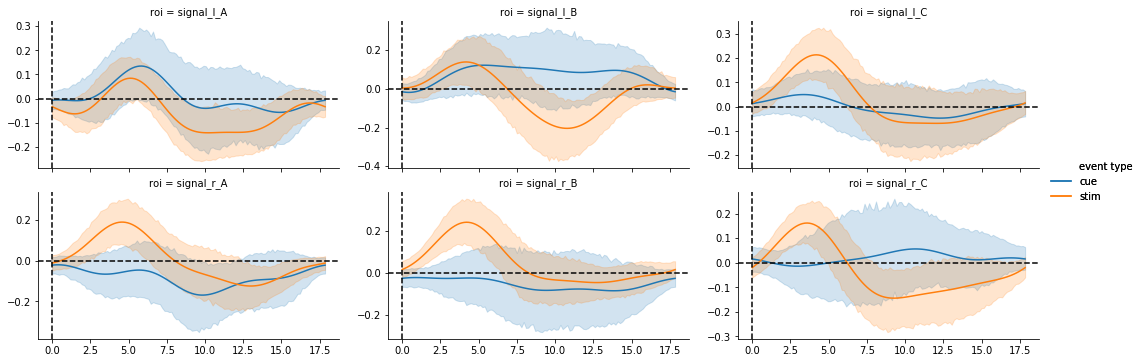

In [10]:
event_types = ['stim', 'cue']
gmodel_full = GroupResponseFitter(df, 
                                  events, 
                                  confounds=confounds.reset_index(),
                                  input_sample_rate=1/3, concatenate_runs=True)
for event_type in event_types:
    gmodel_full.add_event(event_type, basis_set='fourier', n_regressors=7, interval=[0, 18])

gmodel_full.fit()
fg_full = gmodel_full.plot_groupwise_timecourses(event_types=event_types, ci=95, col_wrap=3, plots='covariate', col='roi')
fg_full[0].set_titles(['Subregion A', 'Subregion B', 'Subregion C']*2)

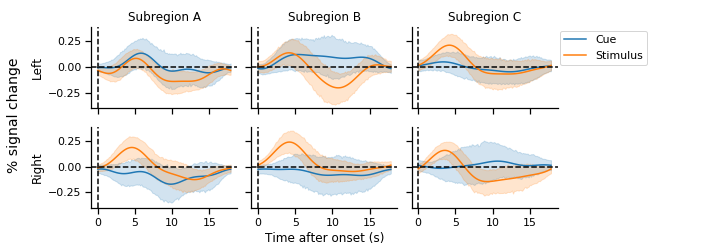

In [75]:
sns.set_context('notebook')
font = {'size'   : 14}
import matplotlib
matplotlib.rc('font', **font)

fg_full = gmodel_full.plot_groupwise_timecourses(event_types=event_types, ci=95, col_wrap=3, plots='covariate', 
                                                 col='roi', sharey=True, legend=False)

for ax, title in zip(fg_full[0].axes.flat, ['Subregion A', 'Subregion B', 'Subregion C', '', '', '']):
    ax.set_title(title)

fg_full[0].axes[0].set_ylabel('Left')
#fg_full[0].axes[2].legend(['Cue', 'Stimulus'])
#h, l = fg_full[0].axes[2].get_legend_handles_labels()
#fg_full[0].axes[2].legend.remove()
fg_full[0].axes[3].set_ylabel('Right')
fg_full[0].axes[4].set_xlabel('Time after onset (s)')
f = plt.gcf()

f.legend(['Cue', 'Stimulus'], loc="upper left", bbox_to_anchor=(1.1,.9))
#f.subplots_adjust(right=.95)
f.text(-.1, 0.45, '% signal change', ha='center', va='center', rotation='vertical')
#f.tight_layout()
f.set_size_inches(7,3.5)

In [76]:
f.savefig('./figures/figure3.pdf', bbox_inches='tight')